In [1]:
import sys  
sys.path.insert(0, './../')
import numpy as np
import bbdc2021 as bbdc
import pandas as pd
from importlib import reload
reload(bbdc)
import tensorflow as tf
from keras import layers
import keras
from keras import backend as K
from itertools import groupby
import matplotlib.pyplot as plt
from matplotlib import colors 
import models.cnn.u_net_1d as unet
reload(unet)

<module 'models.cnn.u_net_1d' from './../models/cnn/u_net_1d.py'>

In [ ]:
pathToDataset = "dataset_fft_l1024_o523_b4/dev/"
X_train, Y_train, timepoints, trainFileList = bbdc.load_data("train.csv", pathToDataset)
X_validation, Y_validation, timepoints, validationFileList = bbdc.load_data("validation.csv", pathToDataset)  
X_test, Y_test, timepoints, testFileList = bbdc.load_data("test.csv", pathToDataset)

inputShape = X_train[0].shape

In [21]:
print(tf.__version__)

2.4.1


In [4]:
channels = [32, 64, 90, 130, 180]
model = unet.u_net(inputShape, channels)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 129)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 320, 32)      12416       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 320, 32)      128         conv1d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 320, 32)      0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [5]:
#Mit crossentropy
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['mae', 'accuracy'])
history = model.fit(X_train,Y_train, batch_size=15, epochs=7, validation_data=(X_validation, Y_validation))

Epoch 1/7
534/534 [==============================] - 137s 152ms/step - loss: 1.2899 - mae: 0.0807 - accuracy: 0.6189 - val_loss: 4.3188 - val_mae: 0.1383 - val_accuracy: 0.1112
Epoch 2/7
534/534 [==============================] - 11s 21ms/step - loss: 0.5820 - mae: 0.0392 - accuracy: 0.8265 - val_loss: 2.1428 - val_mae: 0.0941 - val_accuracy: 0.4554
Epoch 3/7
534/534 [==============================] - 11s 20ms/step - loss: 0.4187 - mae: 0.0293 - accuracy: 0.8711 - val_loss: 2.0154 - val_mae: 0.0711 - val_accuracy: 0.5657
Epoch 4/7
534/534 [==============================] - 11s 20ms/step - loss: 0.3462 - mae: 0.0245 - accuracy: 0.8924 - val_loss: 4.3832 - val_mae: 0.1331 - val_accuracy: 0.1236
Epoch 5/7
534/534 [==============================] - 11s 20ms/step - loss: 0.2809 - mae: 0.0205 - accuracy: 0.9104 - val_loss: 1.1860 - val_mae: 0.0564 - val_accuracy: 0.6872
Epoch 6/7
534/534 [==============================] - 11s 20ms/step - loss: 0.2447 - mae: 0.0179 - accuracy: 0.9210 - val_lo

In [30]:
#Mit Dice
model.compile(optimizer='adam', loss=bbdc.dice_loss, metrics=['mae', 'accuracy'])
history = model.fit(X_train,Y_train, batch_size=15, epochs=10, validation_data=(np.array(X_validation), np.array(Y_validation)))

Epoch 1/15
534/534 [==============================] - 11s 21ms/step - loss: 0.0186 - mae: 0.0066 - accuracy: 0.9681 - val_loss: 0.1035 - val_mae: 0.0287 - val_accuracy: 0.8278
Epoch 2/15
534/534 [==============================] - 11s 21ms/step - loss: 0.0174 - mae: 0.0062 - accuracy: 0.9701 - val_loss: 0.1890 - val_mae: 0.0492 - val_accuracy: 0.6939
Epoch 3/15
534/534 [==============================] - 11s 21ms/step - loss: 0.0167 - mae: 0.0059 - accuracy: 0.9714 - val_loss: 0.2337 - val_mae: 0.0642 - val_accuracy: 0.6032
Epoch 4/15
534/534 [==============================] - 11s 21ms/step - loss: 0.0175 - mae: 0.0061 - accuracy: 0.9700 - val_loss: 0.3501 - val_mae: 0.0950 - val_accuracy: 0.3993
Epoch 5/15
534/534 [==============================] - 11s 21ms/step - loss: 0.0171 - mae: 0.0060 - accuracy: 0.9707 - val_loss: 0.2163 - val_mae: 0.0600 - val_accuracy: 0.6421
Epoch 6/15
534/534 [==============================] - 11s 21ms/step - loss: 0.0167 - mae: 0.0059 - accuracy: 0.9715 - va

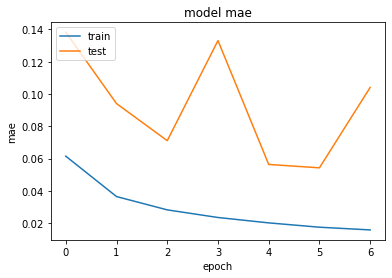

In [6]:
# summarize history for mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

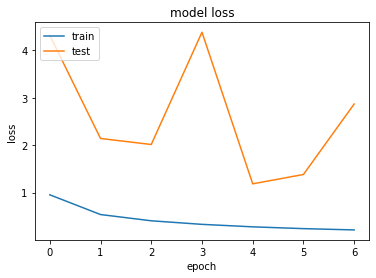

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [8]:
prediction = model.predict(np.array(X_validation))
discretePrediction = (prediction == prediction.max(axis=1)[:,None]).astype(int)

In [10]:
df = bbdc.getPredictionAsSequenceDF(prediction, timepoints, testFileList)
#df.to_csv("Prediction.csv")
df.head()

,filename,onset,offset,event_label
0,09001_mix.wav,0.469687,0.501000,Doorbell
1,09001_mix.wav,0.532312,1.033313,Shatter
2,09001_mix.wav,1.064625,1.095938,Fireworks
3,09001_mix.wav,1.127250,1.127250,Shatter
4,09001_mix.wav,1.158562,1.158562,Fireworks


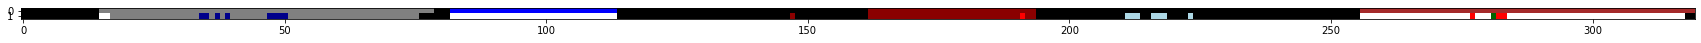

In [27]:
bbdc.plotPredictionAndGT(Y_validation, prediction, 0)